In [2]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
# get_ipython().magic('matplotlib inline')
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#Loading the required RAVDESS DataSet with length of 1439 Audio Files 
os.listdir(path='D:\speech-emotion-recognition-ravdess-data')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = 'D:\speech-emotion-recognition-ravdess-data'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

In [ ]:
#Use the Speech-Recognition API to get the Raw Text from Audio Files, Though Speech Recognition
#is less strong for large chunk of files , so used Error Handling , where when it is not be able to 
#produce the text of a particular Audio File it prints the statement 'error'.Just for understanding Audio
import speech_recognition as sr
r=sr.Recognizer()
for file in range(0 , len(listOfFiles) , 1):
    with sr.AudioFile(listOfFiles[file]) as source:
        audio = r.listen(source)
        try:
            text = r.recognize_google(audio)
            print(text)
        except:
            print('error')

In [4]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
#Plotting the Basic Graphs for understanding of Audio Files :
for file in range(0 , len(listOfFiles) , 1):
    audio , sfreq = lr.load(listOfFiles[file])
    time = np.arange(0 , len(audio)) / sfreq
    
    fig ,ax = plt.subplots()
    ax.plot(time , audio)
    ax.set(xlabel = 'Time (s)' , ylabel = 'Sound Amplitude')
    plt.show()
    
#PLOT THE SEPCTOGRAM
for file in range(0 , len(listOfFiles) , 1):
     sample_rate , samples = wavfile.read(listOfFiles[file])
     frequencies , times, spectrogram = signal.spectrogram(samples, sample_rate) 
     plt.pcolormesh(times, frequencies, spectrogram)
     plt.imshow(spectrogram)
     plt.ylabel('Frequency [Hz]')
     plt.xlabel('Time [sec]')
     plt.show()

In [22]:
#Next Step is In-Depth Visualisation of Audio Fiels and its certain features to plot for.
#They are the Plotting Functions to be called later. 
def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
    
def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            
def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)

In [ ]:
# Here The Data Set is loaded and plots are Visualised by Calling the Plotting Functions . 
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
for file in range(0 , len(listOfFiles) , 1):
    rate, data = wav.read(listOfFiles[file])
    fft_out = fft(data)
    %matplotlib inline
    plt.plot(data, np.abs(fft_out))
    plt.show()
    
signals={}
fft={}
fbank={}
mfccs={}
# load data
for file in range(0 , len(listOfFiles) , 1):
#     rate, data = wavfile.read(listOfFiles[file])
     signal,rate =librosa.load(listOfFiles[file] , sr=44100)
     mask = envelope(signal , rate , 0.0005)
     signals[file] = signal
     fft[file] = calc_fft(signal , rate)
    
     bank = logfbank(signal[:rate] , rate , nfilt = 26, nfft = 1103).T
     fbank[file] = bank
     mel = mfcc(signal[:rate] , rate , numcep =13 , nfilt = 26 , nfft=1103).T
     mfccs[file]=mel

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [24]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [25]:
#The clean Audio Files are redirected to Clean Audio Folder Directory 
import glob,pickle
for file in tqdm(glob.glob(r'D:\speech-emotion-recognition-ravdess-data\\**\\*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'D:\clean-speech\\'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 1440/1440 [00:17<00:00, 81.33it/s]


In [26]:
#Feature Extraction of Audio Files Function 
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [27]:
#Emotions in the RAVDESS dataset to be classified Audio Files based on . 
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#These are the emotions User wants to observe more :
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [28]:
#Load the data and extract features for each sound file
from glob import glob
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'D:\clean-speech\\*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [29]:
#Split the dataset
import librosa
import numpy as np
x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

(576, 180) (192, 180) (576, 2) (192, 2)
(576,) (192,)
03-01-06-01-02-02-01.wav
03-01-03-01-02-01-21.wav
03-01-07-01-02-02-04.wav
03-01-02-02-01-02-24.wav
03-01-07-01-02-02-19.wav
03-01-06-01-01-01-07.wav
03-01-07-01-01-01-16.wav
03-01-02-01-02-02-06.wav
03-01-06-01-01-02-07.wav
03-01-06-02-01-01-15.wav
03-01-02-02-02-02-07.wav
03-01-06-01-02-02-19.wav
03-01-06-02-02-02-05.wav
03-01-06-01-01-01-14.wav
03-01-06-01-02-01-15.wav
03-01-03-02-02-01-06.wav
03-01-02-01-01-02-16.wav
03-01-07-01-01-01-13.wav
03-01-03-02-02-02-24.wav
03-01-02-01-02-02-19.wav
03-01-02-02-01-02-09.wav
03-01-02-01-01-02-07.wav
03-01-03-01-02-01-13.wav
03-01-02-01-02-01-18.wav
03-01-02-02-02-02-03.wav
03-01-02-02-01-01-11.wav
03-01-03-01-02-02-20.wav
03-01-03-02-01-02-06.wav
03-01-06-01-01-02-11.wav
03-01-03-01-02-01-18.wav
03-01-06-01-01-01-15.wav
03-01-07-02-01-02-08.wav
03-01-07-02-01-02-23.wav
03-01-03-01-02-02-10.wav
03-01-06-01-01-01-23.wav
03-01-07-02-02-01-18.wav
03-01-06-02-02-01-22.wav
03-01-07-02-01-01-21.

In [30]:
#Get the shape of the training and testing datasets
# print((x_train.shape[0], x_test.shape[0]))
print((x_train[0], x_test[0]))
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(array([-4.72885620e+02,  6.39674339e+01,  6.17852688e+00,  2.27891064e+01,
       -1.86483326e+01, -8.30456448e+00, -8.13572502e+00, -2.66228986e+00,
       -4.45510054e+00,  9.47255802e+00, -1.61330307e+00, -3.86304617e+00,
       -1.10218763e+00,  1.76132476e+00, -7.75962210e+00,  1.50660962e-01,
       -6.32133102e+00,  1.81471169e-01, -7.18594980e+00, -5.14388180e+00,
       -5.48315811e+00, -9.95529175e-01, -5.72346306e+00, -2.46393800e-01,
       -9.73914909e+00,  5.95409870e+00, -2.98389220e+00,  1.60116804e+00,
       -3.14024353e+00, -9.41481769e-01, -7.19789207e-01,  9.47594762e-01,
       -6.14695930e+00, -3.49499607e+00, -8.83763695e+00, -2.88523197e+00,
       -1.58497643e+00, -8.23680401e-01, -6.02904701e+00, -3.92877340e+00,
        6.35040641e-01,  6.21833563e-01,  6.67138159e-01,  6.82644546e-01,
        7.42090642e-01,  7.68841326e-01,  7.01759040e-01,  6.63775146e-01,
        7.31715798e-01,  6.89814806e-01,  6.42361879e-01,  6.52536094e-01,
        3.14068631e-04, 

In [119]:

# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [120]:
#Train the model
model.fit(x_train,y_train)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [121]:

#SAVING THE MODEL
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "Emotion_Voice_Detection_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [122]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [123]:
#predicting :
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['fearful', 'happy', 'happy', 'calm', 'disgust', 'calm', 'disgust',
       'calm', 'fearful', 'fearful', 'calm', 'fearful', 'happy',
       'fearful', 'fearful', 'happy', 'disgust', 'disgust', 'fearful',
       'calm', 'calm', 'calm', 'happy', 'calm', 'calm', 'calm', 'happy',
       'happy', 'disgust', 'calm', 'calm', 'calm', 'disgust', 'happy',
       'fearful', 'disgust', 'fearful', 'disgust', 'happy', 'fearful',
       'disgust', 'calm', 'happy', 'fearful', 'fearful', 'calm',
       'fearful', 'happy', 'calm', 'calm', 'happy', 'happy', 'happy',
       'disgust', 'disgust', 'disgust', 'disgust', 'happy', 'happy',
       'calm', 'calm', 'happy', 'disgust', 'fearful', 'calm', 'happy',
       'calm', 'happy', 'fearful', 'fearful', 'happy', 'calm', 'calm',
       'calm', 'happy', 'calm', 'calm', 'happy', 'happy', 'disgust',
       'happy', 'happy', 'fearful', 'fearful', 'disgust', 'fearful',
       'happy', 'fearful', 'disgust', 'fearful', 'calm', 'happy', 'happy',
       'happy', 

In [124]:
#Store the Prediction probabilities into CSV file 
import numpy as np
import pandas as pd
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv('predictionfinal.csv')

    predictions                file_names
0       fearful  03-01-06-01-02-02-01.wav
1         happy  03-01-03-01-02-01-21.wav
2         happy  03-01-07-01-02-02-04.wav
3          calm  03-01-02-02-01-02-24.wav
4       disgust  03-01-07-01-02-02-19.wav
..          ...                       ...
187     disgust  03-01-07-01-02-02-14.wav
188       happy  03-01-03-02-02-02-02.wav
189       happy  03-01-06-02-01-01-14.wav
190     disgust  03-01-07-01-01-02-02.wav
191        calm  03-01-02-02-02-01-22.wav

[192 rows x 2 columns]


In [125]:
# accuracy
a=0
b=0
for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            a=a+1
        else:
            b=b+1
print(a/(a+b))            

0.7864583333333334


In [38]:
# confusion matrix
# observed_emotions=['calm', 'happy', 'fearful', 'disgust']
c1,c2,c3,c4=0,0,0,0
h1,h2,h3,h4=0,0,0,0
f1,f2,f3,f4=0,0,0,0
d1,d2,d3,d4=0,0,0,0
for i in range(len(y_pred)):
        if (y_pred[i] == 'calm' and y_test[i]=='calm' ):
            c1=c1+1
        elif(y_pred[i] == 'calm' and y_test[i]=='happy'):
            c2=c2+1
        elif(y_pred[i] == 'calm' and y_test[i]=='fearful'):
            c3=c3+1
        elif(y_pred[i] == 'calm' and y_test[i]=='disgust'):
            c4=c4+1
        elif(y_pred[i] == 'happy' and y_test[i]=='calm'):
            h1=h1+1
        elif(y_pred[i] == 'happy' and y_test[i]=='happy'):
            h2=h2+1    
        elif(y_pred[i] == 'happy' and y_test[i]=='fearful'):
            h3=h3+1
        elif(y_pred[i] == 'happy' and y_test[i]=='disgust'):
            h4=h4+1
        elif(y_pred[i] == 'fearful' and y_test[i]=='calm'):
            f1=f1+1
        elif(y_pred[i] == 'fearful' and y_test[i]=='happy'):
            f2=f2+1    
        elif(y_pred[i] == 'fearful' and y_test[i]=='fearful'):
            f3=f3+1
        elif(y_pred[i] == 'fearful' and y_test[i]=='disgust'):
            f4=f4+1    
        elif(y_pred[i] == 'disgust' and y_test[i]=='calm'):
            d1=d1+1
        elif(y_pred[i] == 'disgust' and y_test[i]=='happy'):
            d2=d2+1    
        elif(y_pred[i] == 'disgust' and y_test[i]=='fearful'):
            d3=d3+1
        elif(y_pred[i] == 'disgust' and y_test[i]=='disgust'):
            d4=d4+1    
print("feeling  calm  happy  fearful  disgust")
print("calm    ",c1, "   ",c2,"     ",c3,"     ",c4 )
print("happy   ",h1, "   ",h2,"    ",h3,"     ",h4 )
print("fearful ",f1, "    ",f2,"    ",f3,"     ",f4 )
print("disgust ",d1, "    ",d2,"    ",d3,"     ",d4 )

feeling  calm  happy  fearful  disgust
calm     42     1       2       2
happy    6     37      8       7
fearful  1      0      37       1
disgust  5      3      6       34


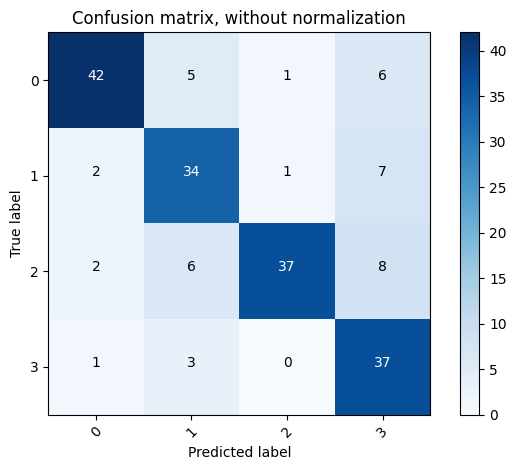

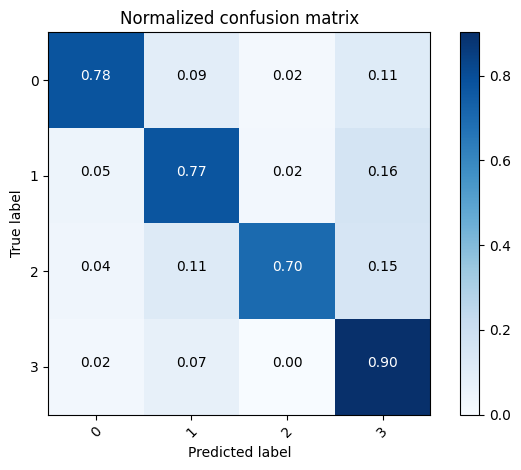

In [40]:
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("")
    else:
        print('')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.arange(4),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.arange(4), normalize=True,
                      title='Normalized confusion matrix')

plt.show()
